In [39]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle
import tensorflow as tf

from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation,  concatenate, Dropout
from tensorflow.keras.models import Model

from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [40]:
path = "/home/rishitamullapudi/Downloads/BHSig260/Hindi/"

In [41]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [42]:
dir_list

['001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',


In [43]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine

In [44]:
orig_groups

[['/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-01.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-02.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-03.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-04.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-05.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-06.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-07.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-08.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-09.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-10.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-11.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-12.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-13.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-1

In [45]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(160, 160)

In [46]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [47]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [48]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


#### Train-Validation-Test Split
* Signatures of 120 people are used for training
* Signatures of 20 people are used for validation
* Signatures of 20 people are used for testing

In [49]:
orig_train, orig_val, orig_test = orig_groups[:120], orig_groups[120:140], orig_groups[140:]
forg_train, forg_val, forg_test = forg_groups[:120], forg_groups[120:140], forg_groups[140:]

In [50]:
orig_train

[['/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-01.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-02.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-03.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-04.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-05.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-06.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-07.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-08.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-09.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-10.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-11.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-12.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-13.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-G-1

In [51]:
forg_train

[['/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-01.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-02.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-03.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-04.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-05.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-06.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-07.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-08.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-09.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-10.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-11.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-12.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-13.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/001/H-S-1-F-1

In [52]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [53]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [54]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

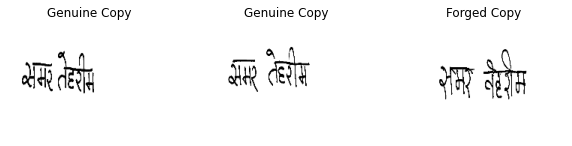

In [55]:
visualize_sample_signature()

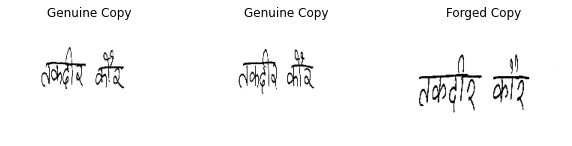

In [56]:
visualize_sample_signature()

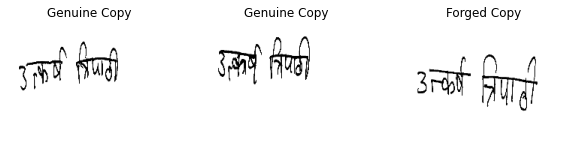

In [57]:
visualize_sample_signature()

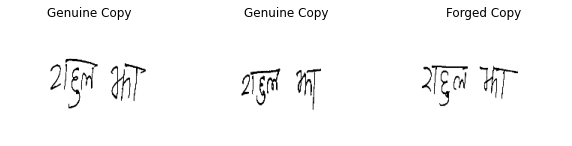

In [58]:
visualize_sample_signature()

In [59]:
def generate_batch(orig_groups, forg_groups, batch_size = 4):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [60]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [61]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [62]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [63]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape))
    #seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1))
    #seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, activation='relu'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, activation='softmax')) # softmax changed to relu
    
    return seq

In [64]:
input_shape=(img_h, img_w, 1)

In [65]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = tf.keras.Model([input_a, input_b], distance)

In [66]:
batch_sz = 124
num_train_samples = 276*120 + 300*120
num_val_samples = num_test_samples = 276*20 + 300*20
num_train_samples, num_val_samples, num_test_samples

(69120, 11520, 11520)

In [67]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [68]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/signet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [69]:
results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 2,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/2
557/557 [==============================] - ETA: 0s - loss: 0.2422
Epoch 00001: saving model to ./Weights/signet-bhsig260-001.h5
557/557 [==============================] - 1738s 3s/step - loss: 0.2422 - val_loss: 0.2553
Epoch 2/2
557/557 [==============================] - ETA: 0s - loss: 0.1317
Epoch 00002: saving model to ./Weights/signet-bhsig260-002.h5
557/557 [==============================] - 1730s 3s/step - loss: 0.1317 - val_loss: 0.2184


#### After observing continuous fall in validation accuracy, I interrupted the training manually

In [74]:
model.save('/home/rishitamullapudi/Downloads/BHSig260/model_trained')


INFO:tensorflow:Assets written to: /home/rishitamullapudi/Downloads/BHSig260/model_trained/assets


In [85]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

#### Load the weights from the epoch which gave the best validation accuracy

In [87]:
model=tf.keras.models.load_model('/home/rishitamullapudi/Downloads/BHSig260/model_trained',compile=False)

In [88]:
test_gen = generate_batch(orig_test, forg_test, 1)

In [89]:
orig_test

[['/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-01.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-02.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-03.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-04.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-05.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-06.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-07.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-08.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-09.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-10.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-11.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-12.tif',
  '/home/rishitamullapudi/Downloads/BHSig260/Hindi/141/H-S-141-G-13.tif',
  '/home/rishitamullapudi/Downloads/BH

In [90]:

pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [91]:
import matplotlib.pyplot as plt

from PIL import Image
pairs=[np.zeros((1, img_h, img_w, 1)) for i in range(2)]
def image_pre_pro(img1,img2):
    pic1 = cv2.imread(img1,0)
    pic_arr1 = pic1
    #plt.imshow(pic_arr1)
    pic2 = cv2.imread(img2,0)
    pic_arr2 = pic2
    plt.imshow(pic_arr2,cmap='gray')
    pic_arr1 = cv2.resize(pic_arr1, (img_w, img_h))
    pic_arr2 = cv2.resize(pic_arr2, (img_w, img_h))
    img1 = np.array(pic_arr1, dtype = np.float64)
    img2 = np.array(pic_arr2, dtype = np.float64)
    img1 /= 255
    img2 /= 255
    img1 = img1[..., np.newaxis]
    img2 = img2[..., np.newaxis]
    #plt.imshow(img2)
    pairs[0][0, :, :, :] = img1
    pairs[1][0, :, :, :] = img2
    print("img1.shape:",pairs[0].shape)


    return pairs[0],pairs[1]


img1.shape: (1, 155, 220, 1)


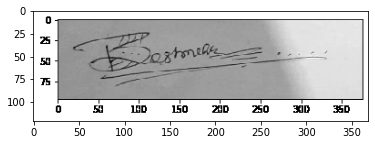

In [93]:
# testing the code 
img1,img2=image_pre_pro('/home/rishitamullapudi/Downloads/BHSig260/Hindi/023/H-S-23-F-02.tif','/home/rishitamullapudi/Desktop/image3.png')

In [94]:
# predict the results 
result = model.predict([img1, img2])


In [95]:
result

array([[0.25946808]], dtype=float32)

In [96]:
diff = result[0][0]

In [97]:
diff

0.25946808

In [98]:
# roc to find out Threshold
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.8126953143906362, 0.27000858978182807)

#### Accuracy = 81.71% and Threshold = 0.55
Thus if the differnce score is less than 0.55, we predict the test image as Genuine and if the difference score is greater than 0.55, we predict it to be as forged

#### Below we see some sample results

In [99]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    #print("img1.shape:",img1.shape)
    #print("img1",img1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

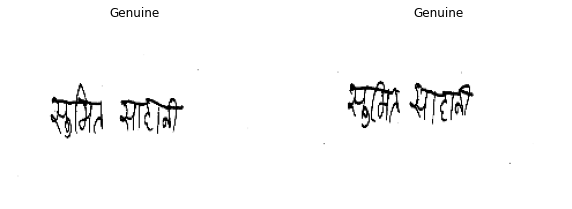

Difference Score =  0.100493595
Its a Genuine Signature


In [100]:
predict_score()

### Note: The first image is always Genuine. Score prediction and classification is done for the second image

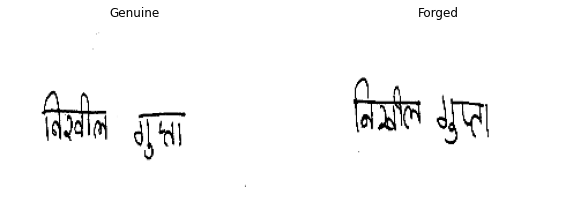

Difference Score =  0.09565172
Its a Genuine Signature


In [101]:
predict_score()

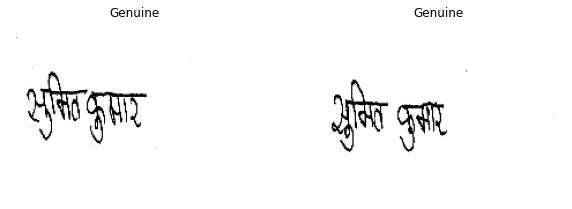

Difference Score =  0.3630084
Its a Forged Signature


In [102]:
predict_score()